### Simple lightGBM example

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = {
    'timeStep': [
        '2023-08-14 20:30:00', '2023-08-14 20:45:00', '2023-08-14 21:00:00',
        '2023-08-14 22:30:00', '2023-08-14 22:45:00',
        '2023-08-14 23:15:00', '2023-08-14 23:45:00'
    ],
    'target': [
        34.0, 36.0, 32.0, 30.0, 34.0, 32.0, 36.0
    ]
}

print({len(data['timeStep'])}, {len(data['target'])})
data_df = pd.DataFrame(data)
data_df['timeStep'] = pd.to_datetime(data_df['timeStep'])
data_df.set_index('timeStep', inplace=True)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['target'], mode='lines+markers', name='Data', line=dict(color='orange')))

fig.update_layout(title='Data',
                  xaxis_title='TimeStep',
                  yaxis_title='Target',
                  legend=dict(x=0, y=1))
fig.show()

# 특성(feature) 생성 - 과거 값들을 특성으로 사용
data_df['target_lag1'] = data_df['target'].shift(1)
data_df['target_lag2'] = data_df['target'].shift(2)
data_df['target_lag3'] = data_df['target'].shift(3)

# 결측치 제거 (처음 몇 개의 lag 값 때문에 생기는 NaN 제거)
data_df = data_df.dropna()

# 입력 변수(X)와 출력 변수(y) 정의
X = data_df[['target_lag1', 'target_lag2', 'target_lag3']]
y = data_df['target']

# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# LightGBM 데이터셋으로 변환
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 모델 파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31
}

# 모델 학습
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[valid_data])

# 예측 수행
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# 예측 결과 평가
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# 예측 결과 출력
predicted_df = X_test.copy()
predicted_df['actual'] = y_test
predicted_df['predicted'] = y_pred
print(predicted_df)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=predicted_df.index, y=predicted_df['actual'], mode='markers', name='Actual'))
fig.add_trace(go.Scatter(x=predicted_df.index, y=predicted_df['predicted'], mode='lines+markers', name='Predicted', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=data_df.index, y=data_df['target'], mode='lines+markers', name='Data', line=dict(color='orange')))

fig.update_layout(title='Actual vs Predicted',
                  xaxis_title='TimeStep',
                  yaxis_title='Target',
                  legend=dict(x=0, y=1))
fig.show()

### lightGBM 시계열 예측 모듈

1. feature vector selection
2. hyperparameter optimization
3. pickle the model and feature extractor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6949
[LightGBM] [Info] Number of data points in the train set: 1601, number of used features: 40
[LightGBM] [Info] Start training from score 113.406796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 3.48


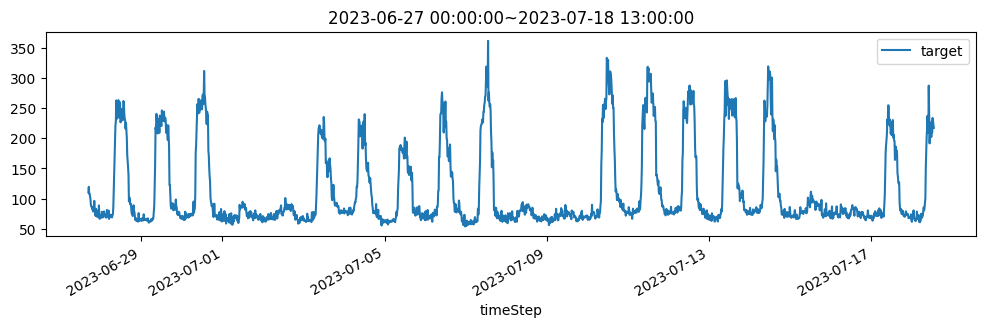

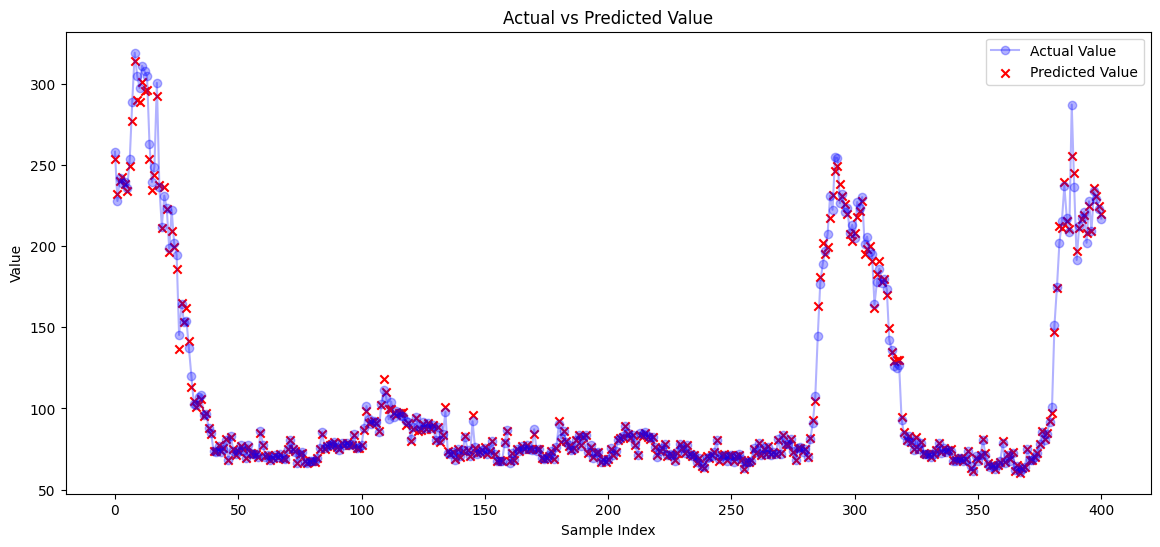

In [1]:
# lightGBM·을 이용한 시계열 예측 모듈
import numpy as np
import pandas as pd
import holidays
import lightgbm as lgb
#from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.tseries.offsets import CustomBusinessDay
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import timedelta

import Utility as Util

file_path = r"/home/ymatics/CodingSpace/2024_AI_BEMS/df_selected.pickle"
df_raw = pd.read_pickle(file_path)
#start_date, end_date = pd.to_datetime('2023-06-01 00:00:00'), pd.to_datetime('2023-07-19 00:00:00')
start_date, end_date = pd.to_datetime('2023-06-27 00:00:00'), pd.to_datetime('2023-07-18 13:00:00')
df = df_raw.loc[start_date:end_date].copy()
Util.plot_data(df=df, title=f"{start_date}~{end_date}", plotType='simple', W=12, H=3)

p_ = 4  # 15min, 4 points/hr
# 시간 기반 피쳐 생성 (대한민국의 주마 및 공휴일 반응)
kr_holidays = holidays.KR()
kr_business_day = CustomBusinessDay(holidays=kr_holidays)

df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)  # 주말 여부
df['is_holiday'] = df.index.isin(kr_holidays).astype(int)  # 공휴일 여부

# 연휴 전후 여부 특성 추가 (설날 및 추석 연휴 포함)
major_holiday_dates = pd.to_datetime([date for date in kr_holidays if kr_holidays[date] in ['설날', '추석']])
df.loc[df.index.isin(major_holiday_dates - pd.DateOffset(days=1)), 'is_holiday'] = 1
df.loc[df.index.isin(major_holiday_dates + pd.DateOffset(days=1)), 'is_holiday'] = 1

# kr_holidays를 datetime으로 변환
holiday_dates = pd.to_datetime(list(kr_holidays.keys()))
#df['is_before_holiday'] = df.index.shift(-1, freq='D').isin(holiday_dates).astype(int)  # 연휴 전날 여부
#df['is_after_holiday'] = df.index.shift(1, freq='D').isin(holiday_dates).astype(int)  # 연휴 다음 날 여부

# 특정 명절 및 중요 휴일 특성 추가
##major_holidays.append('어린이날')
##df['is_major_holiday'] = df.index.to_series().apply(lambda x: 1 if x in kr_holidays and kr_holidays[x] in major_holidays else 0)

# 대체공휴일 보정
for date in kr_holidays:
    if date.weekday() in [5, 6]:
        replacement_date = date + datetime.timedelta(days=1)
        while replacement_date.weekday() in [5, 6] or replacement_date in kr_holidays:
            replacement_date += datetime.timedelta(days=1)
        df.loc[replacement_date, 'is_holiday'] = 1

# 공휴일 전후 주중/주말 여부 추가
#df['is_holiday_weekend'] = ((df['is_holiday'] == 1) & df['is_weekend'] == 1).astype(int)  # 공휴일이 주말인 경우
#df['is_holiday_weekday'] = ((df['is_holiday'] == 1) & df['is_weekend'] == 0).astype(int)  # 공휴일이 주중인 경우
#df['is_month_end'] = df.index.is_month_end.astype(int)  # 월별 마지막 날 여부
#df['is_month_start'] = df.index.is_month_start.astype(int)  # 월초 여부

# 시간 지연 피쳐 생성
df['lag_1p'] = df['target'].shift(1)  # 1h delayed pattern
df['lag_2p'] = df['target'].shift(2)  
df['lag_3p'] = df['target'].shift(3)  
df['lag_4p'] = df['target'].shift(4)  
df['lag_1d_0p'] = df['target'].shift(p_ * 24 + 0)  # 1day = 4p_ x 24h/p_ delayed pattern
df['lag_1d_1p'] = df['target'].shift(p_ * 24 + 1)  
df['lag_1d_2p'] = df['target'].shift(p_ * 24 + 2)  
df['lag_1d_3p'] = df['target'].shift(p_ * 24 + 3)  
df['lag_1d_4p'] = df['target'].shift(p_ * 24 + 4)  
df['lag_1w_0p'] = df['target'].shift(p_ * 24 * 7 + 0)  # 1w = 4p_ x 24h/p_ x 7days delayed pattern
df['lag_1w_1p'] = df['target'].shift(p_ * 24 * 7 + 1)  
df['lag_1w_2p'] = df['target'].shift(p_ * 24 * 7 + 2)  
df['lag_1w_3p'] = df['target'].shift(p_ * 24 * 7 + 3)  
df['lag_1w_4p'] = df['target'].shift(p_ * 24 * 7 + 4) 

# 변동률 및 변동률의 변동률 피쳐 생성
epsilon = 1e-3
shifted = df['target'].shift(1)
divisor = np.where(np.abs(shifted) > epsilon, shifted, np.sign(shifted) * epsilon)
df['rate'] = (df['target'] - df['target'].shift(1)) / divisor
df['diff_rate'] = df['rate'] - df['rate'].shift(1)

shifted_1d = df['target'].shift(p_ * 24)  # 하루 전의 동일 시간대 변동률의 변동률
divisor_1d = np.where(np.abs(shifted_1d) > epsilon, shifted_1d, np.sign(shifted_1d) * epsilon)
df['rate_1d'] = (df['target'] - df['target'].shift(p_ * 24)) / divisor_1d
df['diff_rate_1d'] = df['rate_1d'] - df['rate_1d'].shift(1)

# 이동 평균 피처 생성
df['ma_1d'] = df['target'].rolling(window=p_ * 24).mean()  # 현재부터 1day 통계
df['max_1d'] = df['target'].rolling(window=p_ * 24).max()  
df['min_1d'] = df['target'].rolling(window=p_ * 24).min()  
df['std_1d'] = df['target'].rolling(window=p_ * 24).std() 

df['p1d_ma_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).mean()  # 1일전 1day 통계
df['p1d_max_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).max()  
df['p1d_min_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).min()  
df['p1d_std_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).std() 

df['p1w_ma_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).mean()  # 1주일전 1day 통계
df['p1w_max_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).max()  
df['p1w_min_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).min()  
df['p1w_std_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).std() 

# 추세 및 계절성 분포
df['trend'] = np.arange(len(df))
df['season'] = df['target'] - df['ma_1d']

# 계절성 피처 생성
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

# 주기성 특성 (Cyclical Features)
df['sine_day'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['cosine_day'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# 외부 변수 추가 (예: 기온 데이터)
#external_data = pd.read_csv('external_data.csv')
#df = df.merge(external_data, on='date', how='left')
#df['temperature'] = df['temperature']

# 결측값 처리 (특징 벡터 생성 후 생성된 NaN 처리)
df.bfill(inplace=True)
df.ffill(inplace=True)

# 특성과 타겟 분리
X = df.drop('target', axis=1)
y = df['target']

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# 모델 생성 및 학습
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 60,
    }

model = lgb.train(params,
                  train_data,
                  valid_sets=[test_data],
                  num_boost_round=200
                  )

# 모델 성능 평가
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

# 예측 결과 시각화 (랜덤 샘플링)
y_test_sample = y_test
predictions_sample = predictions

plt.figure(figsize=(14, 6))
plt.plot(y_test_sample.values, label='Actual Value', color='blue', marker='o', alpha=0.3)
plt.scatter(range(len(predictions_sample)), predictions_sample, label='Predicted Value', color='red', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Value')
plt.legend()
plt.show()


In [2]:

# Check for infinity values in 'rate_of_rate' and replace them with NaN
df['rate_of_rate'].replace([float('inf'), -float('inf')], np.nan, inplace=True)
inf_index = df[df.rate_of_rate.isna()].index
print("Indices of infinity values in rate_of_rate:", inf_index.tolist())

# Filter the DataFrame for the specified date range
df_filtered = df[(df.index >= pd.to_datetime('2023-07-08 22:15:00')) & (df.index < pd.to_datetime('2023-07-09 00:30:00'))]

plt.figure(figsize=(14, 6))
#plt.plot(df_filtered['target'], label='Target', color='blue', marker='o', alpha=0.3)
plt.plot(df_filtered['rate'], label='Rate', color='green', marker='o', alpha=0.3)
plt.plot(df_filtered['rate_of_rate'], label='Rate of Rate', color='orange', marker='o', alpha=0.3)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Target, Rate, and Rate of Rate Visualization')
plt.legend()
plt.show()aaa




KeyError: 'rate_of_rate'

In [3]:
# Check for infinity values in the variables
infinity_check = {
    'X_train': np.isinf(X_train).any(),
    'X_test': np.isinf(X_test).any(),
    'y_train': np.isinf(y_train).any(),
    'y_test': np.isinf(y_test).any()
}

print("Infinity Check Results:", infinity_check)

Infinity Check Results: {'X_train': month              False
day                False
weekday            False
is_weekend         False
is_holiday         False
lag_1p             False
lag_2p             False
lag_3p             False
lag_4p             False
lag_1d_0p          False
lag_1d_1p          False
lag_1d_2p          False
lag_1d_3p          False
lag_1d_4p          False
lag_1w_0p          False
lag_1w_1p          False
lag_1w_2p          False
lag_1w_3p          False
lag_1w_4p          False
rate               False
rate_of_rate       False
rate_1d            False
rate_of_rate_1d    False
ma_1d              False
max_1d             False
min_1d             False
std_1d             False
p1d_ma_1d          False
p1d_max_1d         False
p1d_min_1d         False
p1d_std_1d         False
p1w_ma_1d          False
p1w_max_1d         False
p1w_min_1d         False
p1w_std_1d         False
trend              False
season             False
sin_month          False
cos_month     

### Feature Importance

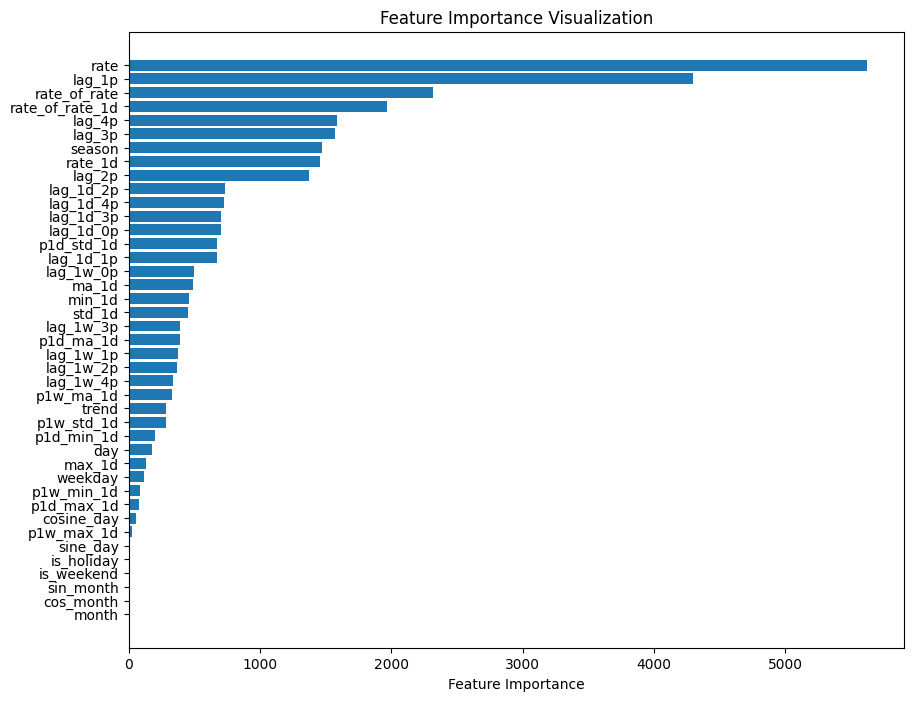

In [4]:
# 특성 중요도 계산 및 시각화 추가
import matplotlib.pyplot as plt  # 시각화를 위한 matplotlib 임포트

# 모델의 특성 중요도 추출
feature_importances = model.feature_importance()
feature_names = X.columns

# 특성 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(importance_df['feature'], importance_df['importance'])  # 수평 막대그래프 생성
plt.xlabel('Feature Importance')  # x축 레이블 설정
plt.title('Feature Importance Visualization')  # 그래프 제목 설정
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 표시
plt.show()  # 그래프 출력

In [7]:
# Feature Reduction using PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# 모델 생성 및 학습
train_data = lgb.Dataset(X_train_reduced, label=y_train)
test_data = lgb.Dataset(X_test_reduced, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 80,
    }

model = lgb.train(params,
                  train_data,
                  valid_sets=[test_data],
                  num_boost_round=500
                  )

# 모델 성능 평가
predictions = model.predict(X_test_reduced)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

/home/ymatics/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

## Feature Reduction

In [ ]:
from sklearn.metrics import mean_squared_error  # MSE calculation import

# Define functions for Feature Reduction
def select_top_n_features(feature_importance, n):
    return feature_importance.head(n)['feature'].tolist()

def select_cumulative_importance(feature_importance, threshold):
    total_importance = feature_importance['importance'].sum()
    feature_importance = feature_importance.copy()
    feature_importance['normalized_importance'] = feature_importance['importance'] / total_importance
    feature_importance['cumulative_importance'] = feature_importance['normalized_importance'].cumsum()
    return feature_importance[feature_importance['cumulative_importance'] <= threshold]['feature'].tolist()

def select_importance_threshold(feature_importance, threshold):
    return feature_importance[feature_importance['importance'] >= threshold]['feature'].tolist()

# Apply each method
top_10_features = select_top_n_features(importance_df, 10)  # Select top 10 features
cumulative_80_features = select_cumulative_importance(importance_df, 0.8)  # Select features with cumulative importance ≤ 80%
importance_threshold_features = select_importance_threshold(importance_df, 0.01)  # Select features with importance ≥ 0.01

# Create new datasets using selected features
X_top_10 = X[top_10_features]
X_cumulative_80 = X[cumulative_80_features]
X_importance_threshold = X[importance_threshold_features]

# Define function to train and evaluate models with reduced feature sets
def train_and_evaluate(X, y, feature_set_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for {feature_set_name}: {mse}")
    return model, mse

# Train and evaluate models with original and reduced feature sets
original_model, original_mse = train_and_evaluate(X, y, "Original Feature Set")
top_10_model, top_10_mse = train_and_evaluate(X_top_10, y, "Top 10 Features")
cumulative_80_model, cumulative_80_mse = train_and_evaluate(X_cumulative_80, y, "Cumulative 80% Importance Features")
importance_threshold_model, importance_threshold_mse = train_and_evaluate(X_importance_threshold, y, "Features with Importance >= 0.01")

# Compare results
results = pd.DataFrame({
    'Feature Set': ['Original', 'Top 10', 'Cumulative 80%', 'Importance >= 0.01'],
    'Number of Features': [X.shape[1], len(top_10_features), len(cumulative_80_features), len(importance_threshold_features)],
    'MSE': [original_mse, top_10_mse, cumulative_80_mse, importance_threshold_mse]
})

print(results)

# Visualize the distribution of selected feature sets
plt.figure(figsize=(12, 6))
plt.bar(results['Feature Set'], results['Number of Features'])
plt.title('Number of Features in Each Set')  # Visualize the number of features for each set
plt.ylabel('Number of Features')  # Set y-axis label
plt.show()

# Visualize MSE comparison
plt.figure(figsize=(12, 6))
plt.bar(results['Feature Set'], results['MSE'])
plt.title('Mean Squared Error (MSE) for Each Feature Set')  # Visualize the MSE for each set
plt.ylabel('MSE')  # Set y-axis label
plt.show()

# Print final selected feature sets
print("\nTop 10 Features:")
print(top_10_features)
print("\nCumulative 80% Importance Features:")
print(cumulative_80_features)
print("\nFeatures with Importance >= 0.01:")
print(importance_threshold_features)


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime
import random
import matplotlib.pyplot as plt

# 1. 센서 데이터 생성
np.random.seed(42)
random.seed(42)
num_samples = 100

dates = [datetime.datetime.now() - datetime.timedelta(minutes=5*i) for i in range(num_samples)]
# 싸인파와 노이즈의 합으로 온도, 습도, 조도 값을 생성
time_indices = np.arange(num_samples)

temperature = 30 + 5 * np.sin(2 * np.pi * time_indices / 1440) + np.random.normal(0, 1, num_samples)  # 평균 30도, 하루 주기의 싸인파 + 노이즈
humidity = 65 + 10 * np.sin(2 * np.pi * time_indices / 1440 + np.pi / 4) + np.random.normal(0, 2, num_samples)  # 평균 65%, 하루 주기의 싸인파 + 노이즈
illumination = 750 + 200 * np.sin(2 * np.pi * time_indices / 1440 + np.pi / 2) + np.random.normal(0, 50, num_samples)  # 평균 750 lx, 하루 주기의 싸인파 + 노이즈

# 데이터프레임으로 생성
data = pd.DataFrame({
    'datetime': dates,
    'temperature': temperature,
    'humidity': humidity,
    'illumination': illumination
})

# 2. Feature Engineering (시간특성 반영)
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['minute'] = data['datetime'].dt.minute
data.drop('datetime', axis=1, inplace=True)

# 3. LightGBM을 활용하여 예측 모델 만들기
# 예측하고자 하는 목표 변수 (타겟): 미래의 온도 (다음 5분 온도 예측)
data['future_temperature'] = data['temperature'].shift(-1)
data.dropna(inplace=True)

# Feature / Target 분리
features = ['temperature', 'humidity', 'illumination', 'hour', 'day_of_week', 'minute']
target = 'future_temperature'

X = data[features]
y = data[target]

# 데이터 분리 (학습용과 테스트용)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31
}

model = lgb.train(params,
                  train_data,
                  valid_sets=[test_data],
                  num_boost_round=1000)

# 4. 모델 성능 평가
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

# 예측 결과 시각화 (랜덤 샘플링)
random_indices = np.random.choice(len(y_test), 100, replace=False)
y_test_sample = y_test.iloc[random_indices]
predictions_sample = predictions[random_indices]

plt.figure(figsize=(14, 6))
plt.plot(y_test_sample.values, label='Actual Temperature', color='blue', marker='o')
plt.plot(predictions_sample, label='Predicted Temperature', color='red', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (Random 100 Samples)')
plt.legend()
plt.show()
